# Hottest Day Date
This investigates how the date of the hottest day of the year in a given region changes with warming, and what causes these changes.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p_water, rho_water
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn, get_heat_capacity
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
import colorcet
from scipy.ndimage import convolve1d
import matplotlib
from matplotlib.colors import ListedColormap

2023-07-14 16:54:50,663 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [179]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'lwup_sfc',
            'flux_t', 'flux_lhe', 'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
    mixed_layer_depth = namelist['mixed_layer_nml']['depth']

## Get datasets

In [180]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [181]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2
ds_global = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(pfull=np.inf, method='nearest')
        ds_use = ds_use.sel(time=slice(use_time_start, np.inf))
        ds_global += [annual_mean(ds_use).load()]
        pbar.update(1)
p_low_level = float(ds_global[0].pfull) * 100     # lowest atmospheric level

100%|██████████| 2/2 [00:36<00:00, 18.28s/it]


## Annual Mean Seasonal Trend
This takes the annual mean, and plots the average surface and near-surface seasonal temperature cycle at the given location.

It also looks into how the winds, insolation, latent heat and relative humidity align with this temperature cycle.

In [182]:
loc = {'lat':25, 'lon': 180}
ds_single_loc = [ds_global[i].sel(lat=loc['lat'], lon=loc['lon'], method='nearest') for i in range(n_exp)]

In [183]:
# Compute times corresponding to peaks in surface temperature
max_summer_time = [ds_single_loc[i].time[ds_single_loc[i].time<8*30][
    np.argmax(ds_single_loc[i].t_surf[ds_single_loc[i].time<8*30].to_numpy())] for i in range(n_exp)]
max_winter_time = [ds_single_loc[i].time[ds_single_loc[i].time>8*30][
    np.argmax(ds_single_loc[i].t_surf[ds_single_loc[i].time>8*30].to_numpy())] for i in range(n_exp)]
if loc['lat'] > 30:
    # in extratropics, only one maxima
    max_winter_time = max_summer_time

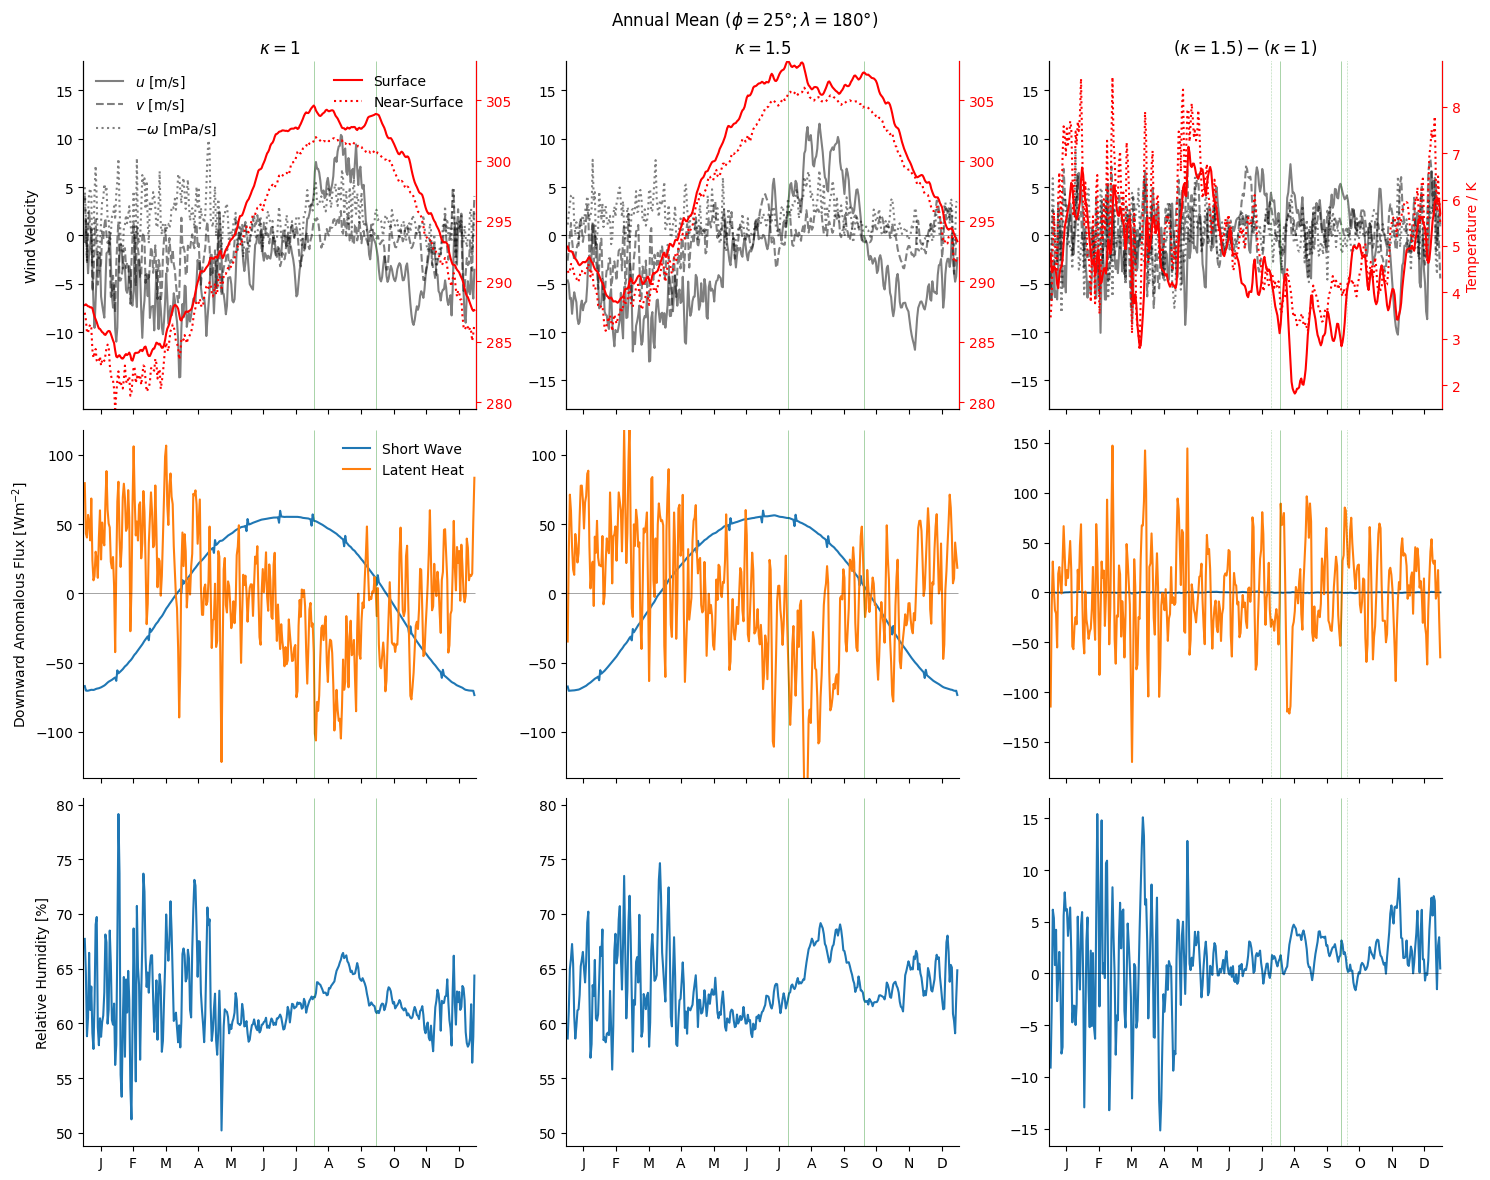

In [184]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(3,3, figsize=(15, 12), sharex=True)
#ax2.set_ylim(-0.012,0.012)
ax2 = []
for i in range(n_exp):
    ax[0, i].plot(ds_single_loc[i].time, ds_single_loc[i].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
    ax[0, i].plot(ds_single_loc[i].time, ds_single_loc[i].vcomp, color='k', alpha=0.5, linestyle='--', label='$v$ [m/s]')
    ax[0, i].plot(ds_single_loc[i].time, -ds_single_loc[i].omega*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
    ax[0, i].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
    ax[0, i].spines['top'].set_visible(False)

    ax2 += [ax[0, i].twinx()]
    ax2[i].spines['top'].set_visible(False)
    ax2[i].plot(ds_single_loc[i].time, ds_single_loc[i].t_surf, color='r', label='Surface')
    ax2[i].plot(ds_single_loc[i].time, ds_single_loc[i].temp, color='r', linestyle=':', label='Near-Surface')
    ax2[i].tick_params(axis='y', colors='red')
    ax2[i].spines['right'].set_color('red')

    ax[1, i].plot(ds_single_loc[i].time, ds_single_loc[i].swdn_sfc-np.mean(ds_single_loc[i].swdn_sfc), label='Short Wave')
    ax[1, i].plot(ds_single_loc[i].time, -(ds_single_loc[i].flux_lhe-np.mean(ds_single_loc[i].flux_lhe)), label='Latent Heat')
    ax[1, i].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
    ax[1, i].spines[['right', 'top']].set_visible(False)

    ax[2, i].plot(ds_single_loc[i].time, 100*ds_single_loc[i].sphum/sphum_sat(ds_single_loc[i].temp,p_low_level))
    ax[2, i].spines[['right', 'top']].set_visible(False)


ax[0, 0].set_xlim(-1,361)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Wind Velocity')
ax[0, 0].legend(frameon=False, loc='upper left')
ax2[0].legend(frameon=False, loc='upper right')
ax[1, 0].set_ylabel('Downward Anomalous Flux [Wm$^{-2}$]')
ax[1, 0].legend(frameon=False)
ax[2, 0].set_ylabel('Relative Humidity [%]')

ax2[0].set_ylim([ds_single_loc[0].temp.min(), ds_single_loc[1].t_surf.max()])
ax2[1].sharey(ax2[0])
ax[0, 0].set_ylim(-18,18)
ax[0, 1].sharey(ax[0, 0])
ax[0, 2].sharey(ax[0, 0])
ax[1, 1].sharey(ax[1, 0])
ax[2, 1].sharey(ax[2, 0])

for i in range(n_exp):
    ax[0, i].set_title(f'$\kappa = {tau_lw[i]}$')
    for ax_use in ax[:, i]:
        ylim = ax_use.get_ylim()
        ax_use.vlines([max_summer_time[i], max_winter_time[i]], *ylim, color='g', alpha=0.6, linewidth=0.4)
        ax_use.set_ylim(ylim)

# In last column, plot difference between optical depth values
ax[0, 2].set_title(f'$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$')
ax[0, 2].plot(ds_single_loc[0].time, ds_single_loc[1].ucomp - ds_single_loc[0].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
ax[0, 2].plot(ds_single_loc[0].time, ds_single_loc[1].vcomp - ds_single_loc[0].vcomp, color='k', alpha=0.5,
              linestyle='--', label='$v$ [m/s]')
ax[0, 2].plot(ds_single_loc[0].time, -(ds_single_loc[1].omega - ds_single_loc[0].omega)*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
ax[0, 2].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0, 2].spines['top'].set_visible(False)
ax2 += [ax[0, 2].twinx()]
ax2[2].spines['top'].set_visible(False)
ax2[2].plot(ds_single_loc[0].time, ds_single_loc[1].t_surf - ds_single_loc[0].t_surf, color='r', label='Surface')
ax2[2].plot(ds_single_loc[0].time, ds_single_loc[1].temp - ds_single_loc[0].temp, color='r', linestyle=':', label='Near-Surface')
ax2[2].tick_params(axis='y', colors='red')
ax2[2].spines['right'].set_color('red')
ax2[2].set_ylabel('Temperature / K', color='r')

ax[1, 2].plot(ds_single_loc[0].time, ds_single_loc[1].swdn_sfc-np.mean(ds_single_loc[1].swdn_sfc) -
              (ds_single_loc[0].swdn_sfc-np.mean(ds_single_loc[0].swdn_sfc)),
              label='Short Wave')
ax[1, 2].plot(ds_single_loc[0].time, -(ds_single_loc[1].flux_lhe-np.mean(ds_single_loc[1].flux_lhe)) -
              -(ds_single_loc[0].flux_lhe-np.mean(ds_single_loc[0].flux_lhe)), label='Latent Heat')
ax[1, 2].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1, 2].spines[['right', 'top']].set_visible(False)

ax[2, 2].plot(ds_single_loc[0].time, 100*(ds_single_loc[1].sphum/sphum_sat(ds_single_loc[1].temp,p_low_level) -
                                          ds_single_loc[0].sphum/sphum_sat(ds_single_loc[0].temp,p_low_level)))
ax[2, 2].spines[['right', 'top']].set_visible(False)
ax[2, 2].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
for ax_use in ax[:, 2]:
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time[0], max_winter_time[0]], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.vlines([max_summer_time[1], max_winter_time[1]], *ylim, color='g', alpha=0.6, linewidth=0.4, linestyle=':')
    ax_use.set_ylim(ylim)


fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Smoothed Temperature and Wind Seasonal Cycle
Below, I smooth the seasonal temperature and wind cycle by averaging over 10 days.
#### Tropics
From this, it seems that in the tropics ($\phi=15\degree; \lambda=180\degree$) the hottest day of the year occurs when the meridional velocity changes direction from southward (negative) to northward (positive). In the warmer $\kappa=1.5$ simulation, this happens earlier hence the hottest day is earlier. The zonal velocity doesn't seem to change that much and on the second passage of the ITCZ through the $15\degree$ latitude, the date seems tio remain the same with warming, hence the second local maxima date remains unchanged.

#### Extratropics
In the extratropics ($\phi=60\degree; \lambda=180\degree$), there doesn't seem that significant a relationship between the wind and the temperature. Except that maybe the wind becomes eastward at an earlier time of the year.

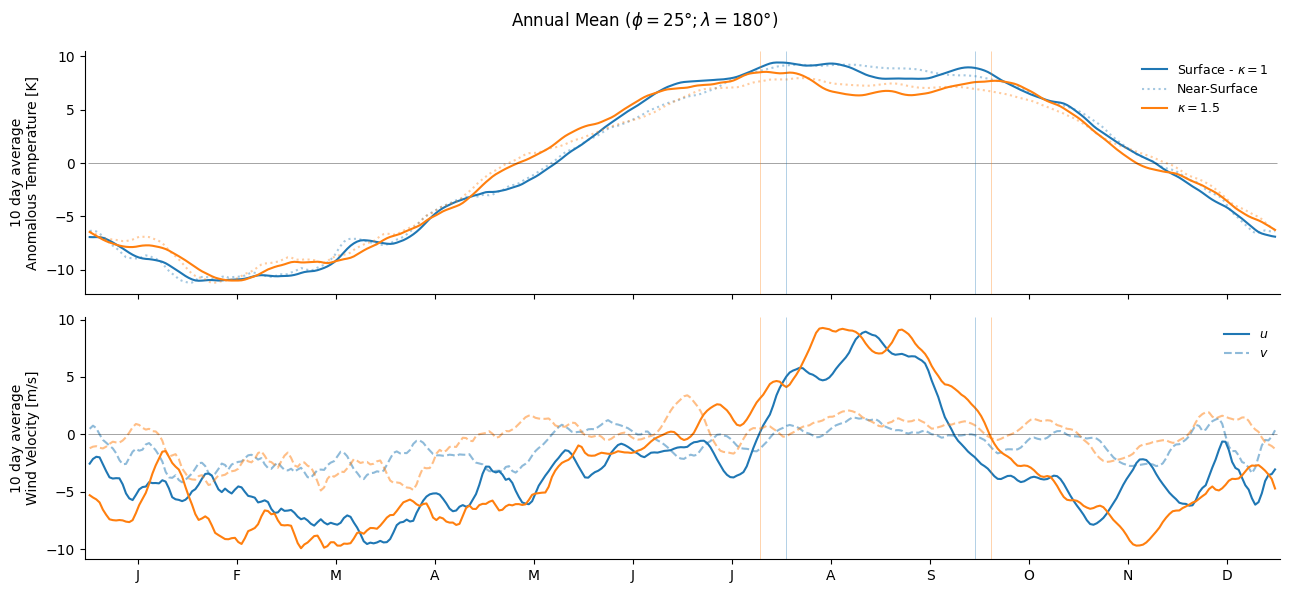

In [185]:
n_day_smooth = 10
smooth_kernel = np.ones(n_day_smooth)/n_day_smooth
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, ax = plt.subplots(2,1, figsize=(13, 6), sharex=True)
for i in range(n_exp):
    ax[0].plot(ds_single_loc[0].time, convolve1d(ds_single_loc[i].t_surf-np.mean(ds_single_loc[i].t_surf), smooth_kernel, mode='wrap'),
               color=default_colors[i], label=f'Surface - $\kappa={tau_lw[i]}$' if i==0 else f'$\kappa={tau_lw[i]}$')
    ax[0].plot(ds_single_loc[0].time, convolve1d(ds_single_loc[i].temp-np.mean(ds_single_loc[i].temp), smooth_kernel, mode='wrap'),
               color=default_colors[i], linestyle=':', label='Near-Surface' if i==0 else None, alpha=0.4)
    ax[1].plot(ds_single_loc[0].time, convolve1d(ds_single_loc[i].ucomp, smooth_kernel, mode='wrap'), color=default_colors[i],
               label='$u$' if i==0 else None)
    ax[1].plot(ds_single_loc[0].time, convolve1d(ds_single_loc[i].vcomp, smooth_kernel, mode='wrap'), color=default_colors[i],
               linestyle='--', label='$v$' if i==0 else None, alpha=0.5)
ax[0].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0].set_xlim(-1,361)
ax[0].legend(frameon=False, fontsize=9)
ax[1].legend(frameon=False, fontsize=9)
for i in range(n_exp):
    for ax_use in ax:
        ax_use.spines[['right', 'top']].set_visible(False)
        ylim = ax_use.get_ylim()
        ax_use.vlines([max_summer_time[i], max_winter_time[i]], *ylim, color=default_colors[i], alpha=0.6, linewidth=0.4)
        ax_use.set_ylim(ylim)
ax[0].set_ylabel(f'{n_day_smooth} day average\nAnomalous Temperature [K]')
ax[1].set_ylabel(f'{n_day_smooth} day average\nWind Velocity [m/s]')
ax[0].set_xticks(*month_ticks)
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

## Temperature Tendency
At the surface, the temperature tendency, $\partial T/\partial t$, can be computed through the surface energy budget:
$$C\frac{\partial T}{\partial t} = F = SW^{\downarrow} + LW^{\downarrow} - LW^{\uparrow} - LH^{\uparrow} - SH^{\uparrow}$$
Where $F$ is the net flux into the surface (units of $Wm^{-2}$), and $C = c_{p, water}\rho_{water} h$ is the heat capacity of the ocean mixed layer in units of $Jkg^{-1}m^{-2}$.

The plot below confirms that the two sides of the equation match up.

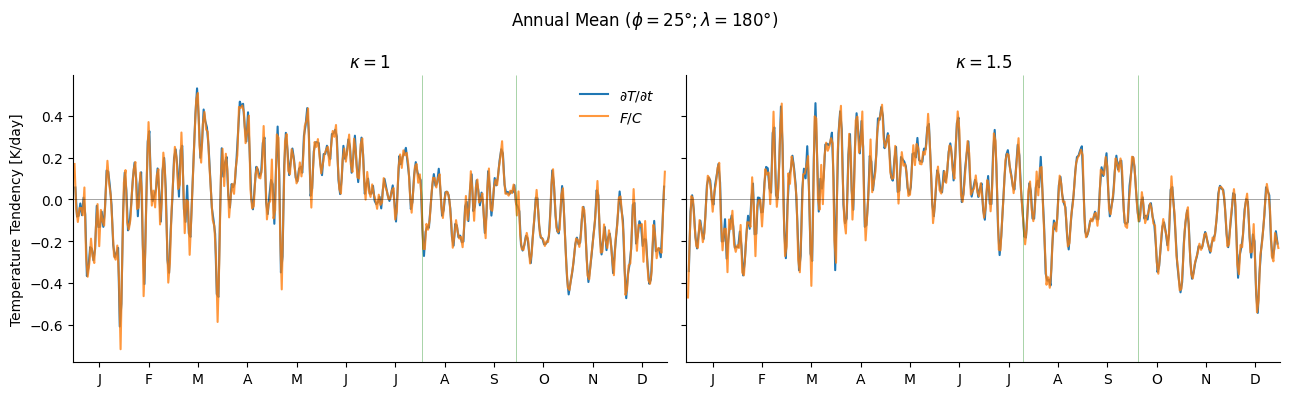

In [186]:
# Compute temperature tendency
heat_capacity = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth)
# flux_lhe and flux_t defined as upward being positive
net_flux_surface = [ds_single_loc[i].swdn_sfc + ds_single_loc[i].lwdn_sfc - ds_single_loc[i].lwup_sfc -
                    ds_single_loc[i].flux_lhe - ds_single_loc[i].flux_t for i in range(n_exp)]
day_seconds = 24*60**2
fig, ax = plt.subplots(1,2, figsize=(13, 4), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].spines[['right', 'top']].set_visible(False)
    ax[i].plot(ds_single_loc[i].time[:-1], np.ediff1d(ds_single_loc[i].t_surf), label='$\partial T/\partial t$')
    ax[i].plot(ds_single_loc[i].time-0.5, net_flux_surface[i]/ heat_capacity * day_seconds, alpha=0.8, label='$F/C$')
    ax[i].hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
    ylim = ax[i].get_ylim()
    ax[i].vlines([max_summer_time[i], max_winter_time[i]], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax[i].set_ylim(ylim)
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax[0].legend(frameon=False)
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Temperature Tendency [K/day]')


fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Breakdown of Surface Fluxes
The second plot below decomposes the temperature tendencies into contributions from each of the different surface fluxes. The third plot is the same as the second, but I have removed the mean for each flux i.e. it shows the anomaly from the mean for each flux.

For a given day in the last plot, I sum the temperature tendencies over the preceeding 10 days.

#### Tropics
In the tropics ($\phi=15\degree; \lambda=180\degree$), around the hottest day, we see a reduction in the cooling provided by longwave radiation with warming i.e. more CO2 in atmosphere, increases downwelling longwave radiation. The latent heat doesn't seem to change very much, possibly because the winds weaken which leads to a heating effect but the average temperature increases leading to a cooling effect, so these may offset each other.

#### Extratropics
In the extratropics ($\phi=60\degree; \lambda=180\degree$), around the hottest day, we see a reduction in the cooling provided by longwave radiation with warming i.e. more CO2 in atmosphere, increases downwelling longwave radiation. We also see an increase in the mean cooling provided by latent heat as well as an amplification of the seasonal cycle (this is shown more clearly in the plot one beneath this one). Overall, this increased cooling by latent heat dominates and the hottest day of the year moves to an earlier date with global warming.

In [187]:
def sum_over_days(var, n_days, direction='before', axis=-1):
    """
    Assumes var wraps around i.e. when reaches the end, it wraps around to the beginning.
    Args:
        var: Variable to average over n_days
        n_days: Number of days to average over
        direction: If `before`, it will sum over the previous n_days
            If `after`, it will sum over the n_days after the given day.
        axis: Which axis to convolve over
    Returns:
        var_av[i] is the sum from var[i-n_days] to var_av[i-1] if direction = `before`.
        var_av[i] is the sum from var[i+1] to var_av[i+n_days] if direction = `after`.
    """
    kernel_array = np.zeros(2*n_days+1)
    kernel_array[:n_days] = 1
    if direction == 'before':
        kernel_array = np.flip(kernel_array)
    elif direction != 'after':
        raise ValueError(f'direction given, {direction}, is not valid. It must be `before` or `after`')
    return convolve1d(var, kernel_array, mode='wrap', axis=axis)

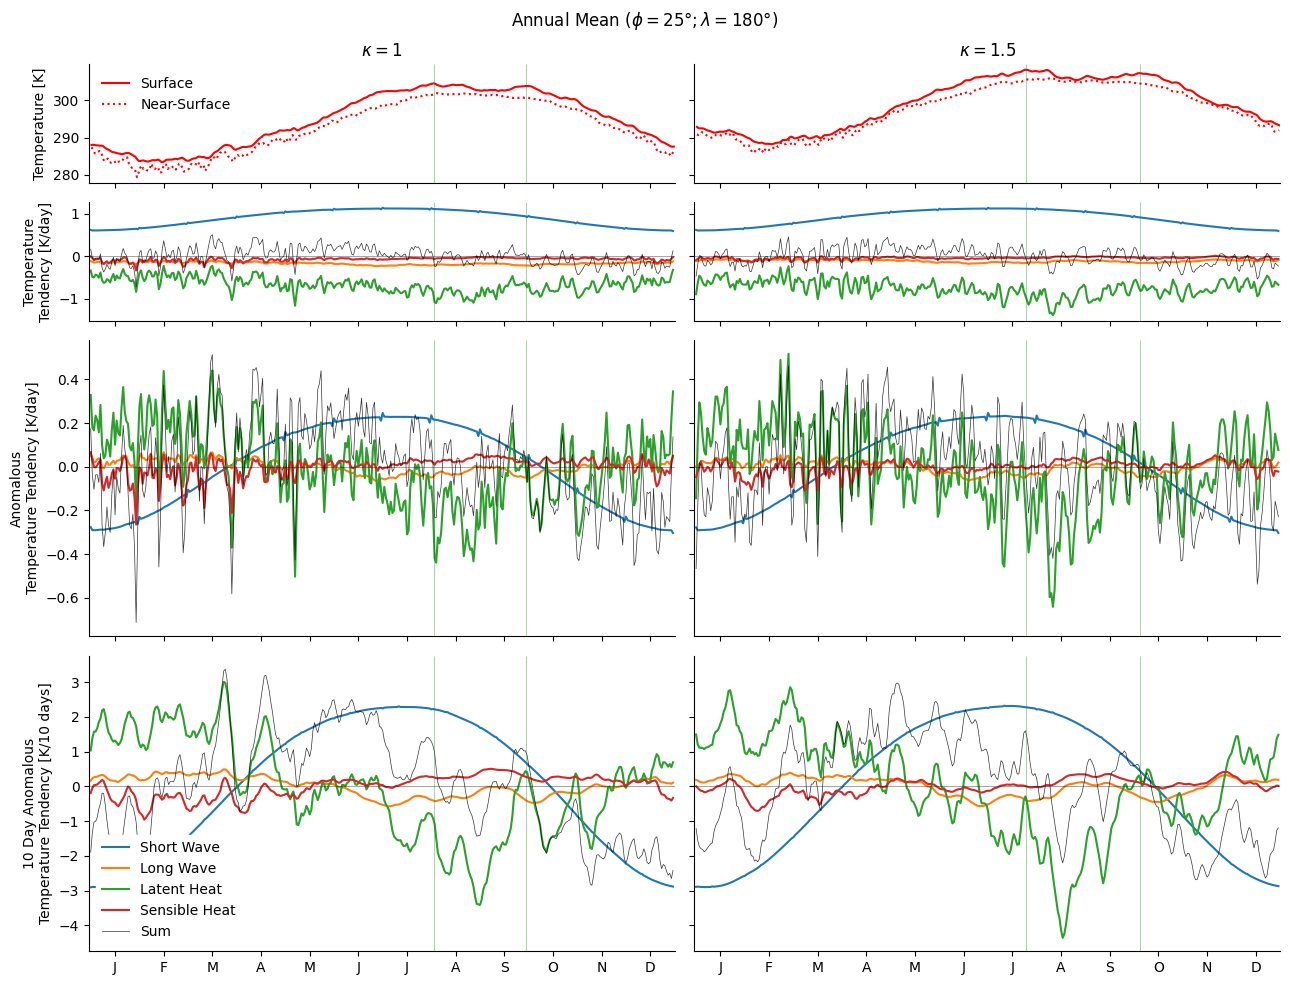

In [188]:
flux_names = ['Short Wave', 'Long Wave', 'Latent Heat', 'Sensible Heat']
n_day_sum = 10      # for one plot, sum temperature tendency over preceeding `n_day_sum` days.

fig, ax = plt.subplots(4,2, figsize=(13, 10), gridspec_kw={'height_ratios': [1, 1, 2.5, 2.5]}, sharex=True, sharey='row')
for j in range(n_exp):
    ax[0, j].plot(ds_single_loc[j].time, ds_single_loc[j].t_surf, color='r', label='Surface')
    ax[0, j].plot(ds_single_loc[j].time, ds_single_loc[j].temp, color='r', linestyle=':', label='Near-Surface')
    for i, flux in enumerate([ds_single_loc[j].swdn_sfc, ds_single_loc[j].lwdn_sfc - ds_single_loc[j].lwup_sfc,
                              -ds_single_loc[j].flux_lhe, -ds_single_loc[j].flux_t]):
        ax[1, j].plot(ds_single_loc[j].time-0.5, flux/heat_capacity * day_seconds)
        ax[2, j].plot(ds_single_loc[j].time-0.5, (flux-np.mean(flux))/heat_capacity * day_seconds)
        ax[3, j].plot(ds_single_loc[j].time-0.5,sum_over_days((flux-np.mean(flux))/heat_capacity * day_seconds, n_day_sum),
                   label = flux_names[i])
    ax[3, j].plot(ds_single_loc[j].time-0.5,
                  sum_over_days((net_flux_surface[j]-np.mean(net_flux_surface[j]))/heat_capacity * day_seconds, n_day_sum),
                  color='k', label='Sum', alpha=0.8, lw=0.5)
    ax[1, j].plot(ds_single_loc[j].time-0.5, net_flux_surface[j]/ heat_capacity * day_seconds, color='k', alpha=0.8, lw=0.5)
    ax[2, j].plot(ds_single_loc[j].time-0.5, (net_flux_surface[j]-np.mean(net_flux_surface[j]))/ heat_capacity * day_seconds,
               color='k', alpha=0.8, lw=0.5)
for j in range(n_exp):
    ax[0, j].set_title(f'$\kappa={tau_lw[j]}$')
    for ax_use in ax[:, j]:
        ax_use.spines[['right', 'top']].set_visible(False)
        ylim = ax_use.get_ylim()
        ax_use.vlines([max_summer_time[j], max_winter_time[j]], *ylim, color='g', alpha=0.6, linewidth=0.4)
        ax_use.set_ylim(ylim)
        ax_use.hlines(0,-10,370, color='k', linewidth=0.5, alpha=0.5)
ax[0, 0].set_xlim(-1,360)
ax[0, 0].legend(frameon=False)
ax[3, 0].legend(edgecolor='white', loc='lower left', framealpha=1)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Temperature [K]')
ax[1, 0].set_ylabel('Temperature\nTendency [K/day]')
ax[2, 0].set_ylabel('Anomalous\nTemperature Tendency [K/day]')
ax[3, 0].set_ylabel(f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()

### Change to Mean and Seasonal Cycle
The dots in the plots below indicate the change in the mean of the quantity indicated i.e. $\delta \overline{X}$. The lines show the change in the seasonal cycle i.e. $\delta (X-\overline{X})$.
The bottom plot is the same as the second plot except it shows the average over a 10 day period centered on the given day.

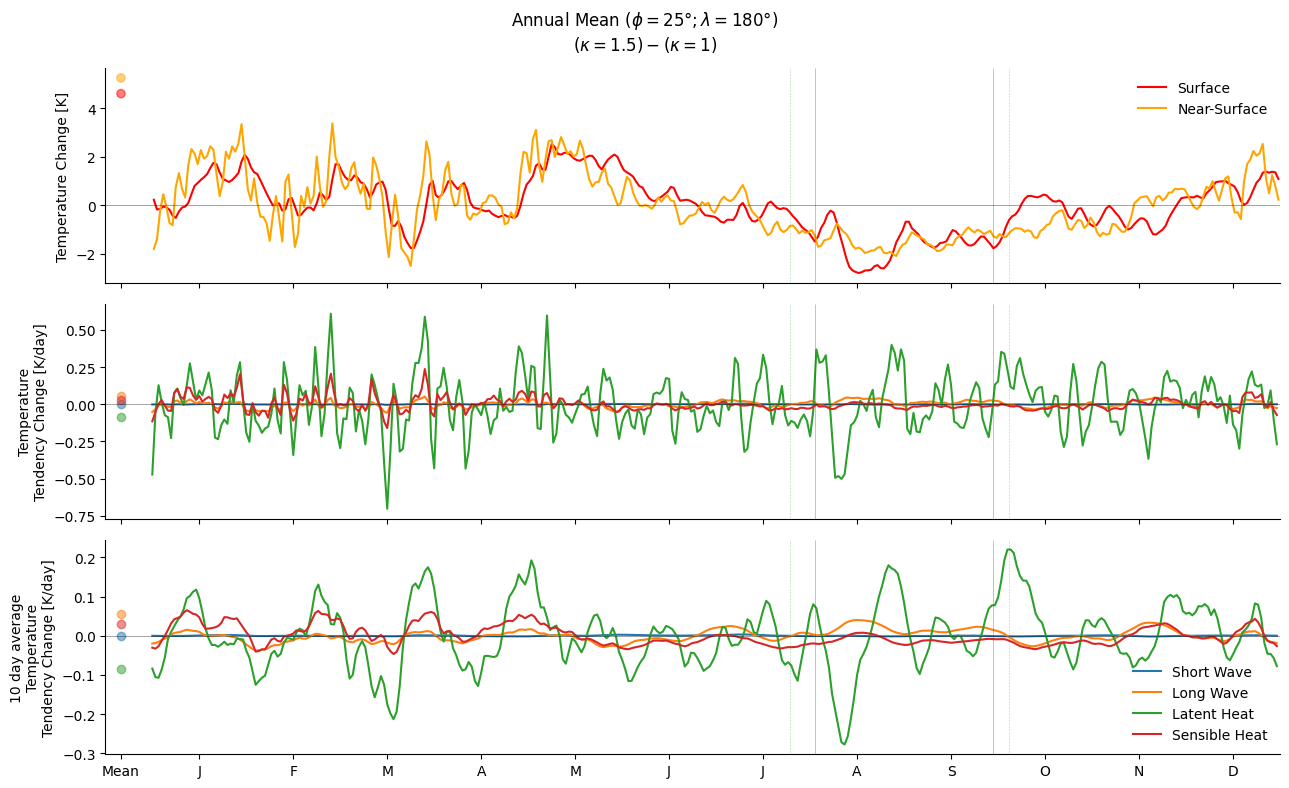

In [189]:
fig, ax = plt.subplots(3,1, figsize=(13, 8), sharex=True)
ax[0].plot(ds_single_loc[0].time, (ds_single_loc[1].t_surf-np.mean(ds_single_loc[1].t_surf)) -
           (ds_single_loc[0].t_surf-np.mean(ds_single_loc[0].t_surf)), color='r', label='Surface')
ax[0].plot(ds_single_loc[0].time, (ds_single_loc[1].temp-np.mean(ds_single_loc[1].temp)) -
           (ds_single_loc[0].temp-np.mean(ds_single_loc[0].temp)), color='orange', label='Near-Surface')
ax[0].scatter([-10, -10], [np.mean(ds_single_loc[1][var]) - np.mean(ds_single_loc[0][var]) for var in ['t_surf', 'temp']],
              color=['red', 'orange'], alpha=0.5)
for i, flux in enumerate([ds_single_loc[1].swdn_sfc-ds_single_loc[0].swdn_sfc,
                          (ds_single_loc[1].lwdn_sfc - ds_single_loc[1].lwup_sfc) -
                          (ds_single_loc[0].lwdn_sfc - ds_single_loc[0].lwup_sfc),
                          -ds_single_loc[1].flux_lhe - (-ds_single_loc[0].flux_lhe),
                          -ds_single_loc[1].flux_t - (-ds_single_loc[0].flux_t)]):
    ax[1].plot(ds_single_loc[j].time-0.5, (flux-np.mean(flux))/heat_capacity * day_seconds, label = flux_names[i])
    ax[2].plot(ds_single_loc[j].time-0.5, convolve1d((flux-np.mean(flux))/heat_capacity * day_seconds, smooth_kernel, mode='wrap'),
               label = flux_names[i])
    ax[1].scatter(-10, np.mean(flux)/heat_capacity * day_seconds, alpha=0.5)
    ax[2].scatter(-10, np.mean(flux)/heat_capacity * day_seconds, alpha=0.5)
ax[0].legend(frameon=False)
ax[2].legend(frameon=False)

for ax_use in ax:
    ax_use.spines[['right', 'top']].set_visible(False)
    ylim = ax_use.get_ylim()
    for j in range(n_exp):
        ax_use.vlines([max_summer_time[j], max_winter_time[j]], *ylim, color='g', alpha=0.6, linewidth=0.4,
                      linestyles='-' if j==0 else ':')
    ax_use.set_ylim(ylim)
    ax_use.hlines(0,-15,370, color='k', linewidth=0.5, alpha=0.5)
ax[0].set_xticks(np.append(month_ticks[0], -10), np.append(month_ticks[1], 'Mean'))
ax[0].set_xlim(-15,360)
ax[0].set_ylabel('Temperature Change [K]')
ax[1].set_ylabel('Temperature\nTendency Change [K/day]')
ax[2].set_ylabel(f'{n_day_smooth} day average\nTemperature\nTendency Change [K/day]')
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)\n"
             f"$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$")
plt.tight_layout()

### Latent Heat Decomposition
I think the latent heat formula in *Isca* is linearly related to the bulk formula for evaporation:
$$E = \rho_aC_{drag}|v_a|(q^*_s - q_a)$$

According to [Frierson 2006](https://journals.ametsoc.org/view/journals/atsc/63/10/jas3753.1.xml), $v_a$, $\rho_a$ and $q_a$ are the horizontal wind, density and specific humidity evaluated at the lowest atmospheric level. $q_s^*$ is the saturation specific humidity at the surface temperature. The drag coefficient, $C_{drag}$, is calculated according to a simplified Monin–Obukhov similarity (MOS) theory.\

As the $C_{drag}$ term is quite complicated, below I see how the latent heat flux output by Isca and $|v_a|(q^*_s - q_a)$ compare. They seem to match up pretty well hence I ignore the drag term in the following analysis.

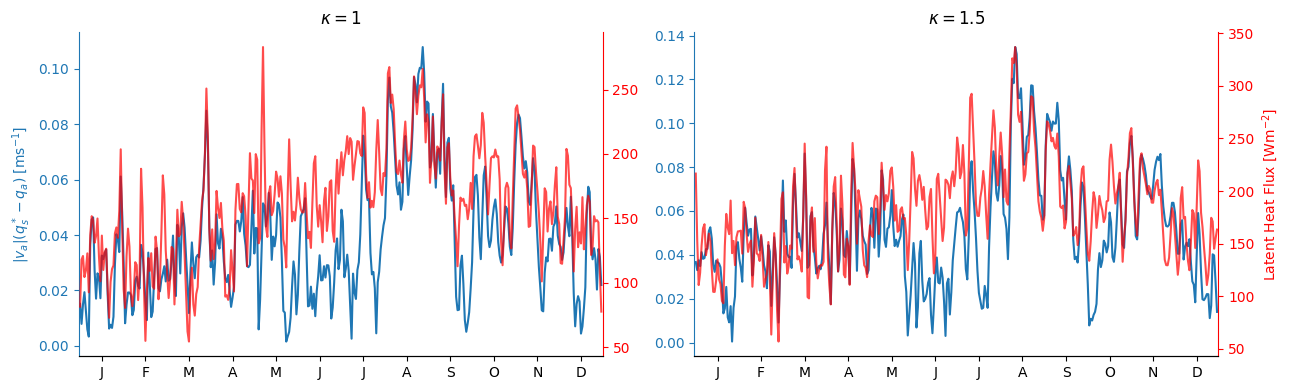

In [190]:
# omega = -ds_single_loc[0].omega / (1.293 * 9.81)
p_surface = np.mean(ds_single_loc[0].ps)       # surface pressure level - assume constant
wind_speed = [np.sqrt(ds_single_loc[i].vcomp**2 + ds_single_loc[i].ucomp**2) for i in range(n_exp)]
sphum_diff = [sphum_sat(ds_single_loc[i].t_surf, p_surface) - ds_single_loc[i].sphum for i in range(n_exp)]
fig, ax = plt.subplots(1,2, figsize=(13, 4), sharex=True)
ax2 = []
for i in range(n_exp):
    ax[i].plot(ds_single_loc[0].time-0.5, wind_speed[i] * sphum_diff[i], color=default_colors[0])
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].spines['left'].set_color(default_colors[0])
    ax[i].tick_params(axis='y', colors=default_colors[0])
    ax2 += [ax[i].twinx()]
    ax2[i].spines[['top', 'left']].set_visible(False)
    ax2[i].plot(ds_single_loc[i].time-0.5, ds_single_loc[i].flux_lhe, color='r', alpha=0.7)
    ax2[i].tick_params(axis='y', colors='r')
    ax2[i].spines['right'].set_color('r')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax2[-1].set_ylabel('Latent Heat Flux [Wm$^{-2}$]', color='r')
ax[0].set_ylabel('$|v_a|(q^*_s - q_a)$ [ms$^{-1}$]', color=default_colors[0])

ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
plt.tight_layout();

The $|v_a|(q^*_s - q_a)$ term can be written as $|v_a|(q^*(T_s) - r_aq^*(T_a))$ and as such depends on near-surface wind speed $v_a$, surface temperature $T_s$, near-surface temperature $T_{a}$ and near-surface relative humidity $r_a$.

If I do a taylor expansion of $q^*(T_a)$ about $T_s$, I can write this as $|v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg)$ where $T_{a-s} = T_{a}-T_{s}$ and $\alpha_s$ is the clausius clapeyron parameter evaluated at the surface. The comparison between the blue and orange lines below confirms that this is a good approximation.

Given this form of the latent heat contribution, I do a taylor series expanding the latent heat in terms of deviations from the mean of $|v_a|$, $T_s$, $T_{a-s}$ and $r_a$ i.e.

$$LH \approx |v_a|q^*(T_s)\bigg(1 - r_a(1 + \alpha_s T_{a-s})\bigg) \approx |\overline{v_a}|q^*(\overline{T_s})\bigg(1 - \overline{r_a}(1 + \overline{\alpha_s} \overline{T_{a-s}})\bigg) + \mu_{v_a}\Delta v_a + \mu_{r_a}\Delta r_a + \mu_{T_{a-s}} \Delta T_{a-s} +
\mu_{T_s} \Delta T_s + \frac{1}{2}\mu_{T^2_s} \Delta T^2_s  + \mu_{T_sv_a} \Delta T_s \Delta v_a$$

Where the $\mu$ terms represent the taylor coefficients i.e. $\mu_{T_s} = \frac{\partial LH}{\partial T_s}$ and $\mu_{T^2_s} = \frac{\partial^2 LH}{\partial T^2_s}$.

The $\Delta$ terms reflect the difference to the mean i.e. $\Delta T_s = T_s - \overline{T_s}$.

This approximation shown by the difference between the orange and green lines is fairly good, if not as good as the initial one.

In [191]:
def get_lh_taylor_decomp(dataset, p_low=p_low_level, p_s=p_surface, mean_axis=None):
    v_mean = np.mean(np.sqrt(dataset.vcomp**2 + dataset.ucomp**2), axis=mean_axis)

    temp_s_mean = np.mean(dataset.t_surf, axis=mean_axis)

    r_a = dataset.sphum/sphum_sat(dataset.temp, p_low)
    r_a_mean = np.mean(r_a, axis=mean_axis)

    temp_diff = dataset.temp - dataset.t_surf
    temp_diff_mean = np.mean(temp_diff, axis=mean_axis)

    q_sat_s_mean = sphum_sat(temp_s_mean, p_s)
    alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_s)

    # this is the difference to the mean i.e. the seasonal variation
    delta_vars = {'wind': np.sqrt(dataset.vcomp**2 + dataset.ucomp**2) - v_mean,
                  'temp_s': dataset.t_surf - temp_s_mean,
                  'r_a': r_a - r_a_mean,
                  'temp_diff': temp_diff - temp_diff_mean}
    delta_vars['wind_temp_s'] = delta_vars['wind'] * delta_vars['temp_s']
    delta_vars['temp_s_squared'] = delta_vars['temp_s'] **2
    delta_vars['r_temp_s'] = delta_vars['r_a'] * delta_vars['temp_s']
    delta_vars['wind_r'] = delta_vars['wind'] * delta_vars['r_a']
    delta_vars['tempdiff_temp_s'] = delta_vars['temp_diff'] * delta_vars['temp_s']
    delta_vars['wind_tempdiff'] = delta_vars['temp_diff'] * delta_vars['wind']

    lh_mean = v_mean * q_sat_s_mean * (1 - r_a_mean * (1 + temp_diff_mean * alpha_s_mean))

    # IMPORTANT - must have delta terms as first term in product to ensure correct shape when include latitude and longitude
    # I.e. when using the mean_axis variable
    lh_taylor_coefs = {}
    lh_taylor_coefs['wind'] = lh_mean / v_mean
    lh_taylor_coefs['temp_s'] = v_mean * q_sat_s_mean * alpha_s_mean * (
            1 - r_a_mean - (r_a_mean * temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2))
    lh_taylor_coefs['r_a'] = - v_mean * q_sat_s_mean * (1 + temp_diff_mean * alpha_s_mean)
    lh_taylor_coefs['temp_diff'] = - v_mean * q_sat_s_mean * r_a_mean * alpha_s_mean
    lh_taylor_coefs['wind_temp_s'] = lh_taylor_coefs['temp_s'] / v_mean
    lh_taylor_coefs['temp_s_squared'] = v_mean * q_sat_s_mean * alpha_s_mean / temp_s_mean ** 2 * (
            alpha_s_mean * temp_s_mean * ((1-r_a_mean)*temp_s_mean - r_a_mean*alpha_s_mean*temp_diff_mean*temp_s_mean +
                                          6*r_a_mean*temp_diff_mean) -
            2*(1-r_a_mean)*temp_s_mean - 6*r_a_mean*temp_diff_mean) * 0.5  # squared taylor series, need 0.5 factor
    lh_taylor_coefs['r_temp_s'] = - v_mean * q_sat_s_mean * alpha_s_mean * (1 + (temp_diff_mean / temp_s_mean) *
                                                                            (alpha_s_mean * temp_s_mean - 2))
    lh_taylor_coefs['wind_r'] = lh_taylor_coefs['r_a']/v_mean
    lh_taylor_coefs['tempdiff_temp_s'] = -v_mean * q_sat_s_mean * alpha_s_mean * \
                                         ((r_a_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2))
    lh_taylor_coefs['wind_tempdiff'] = lh_taylor_coefs['temp_diff']/v_mean
    lh_taylor_terms = {var: delta_vars[var] * lh_taylor_coefs[var] for var in delta_vars}
    return lh_mean, lh_taylor_terms, lh_taylor_coefs

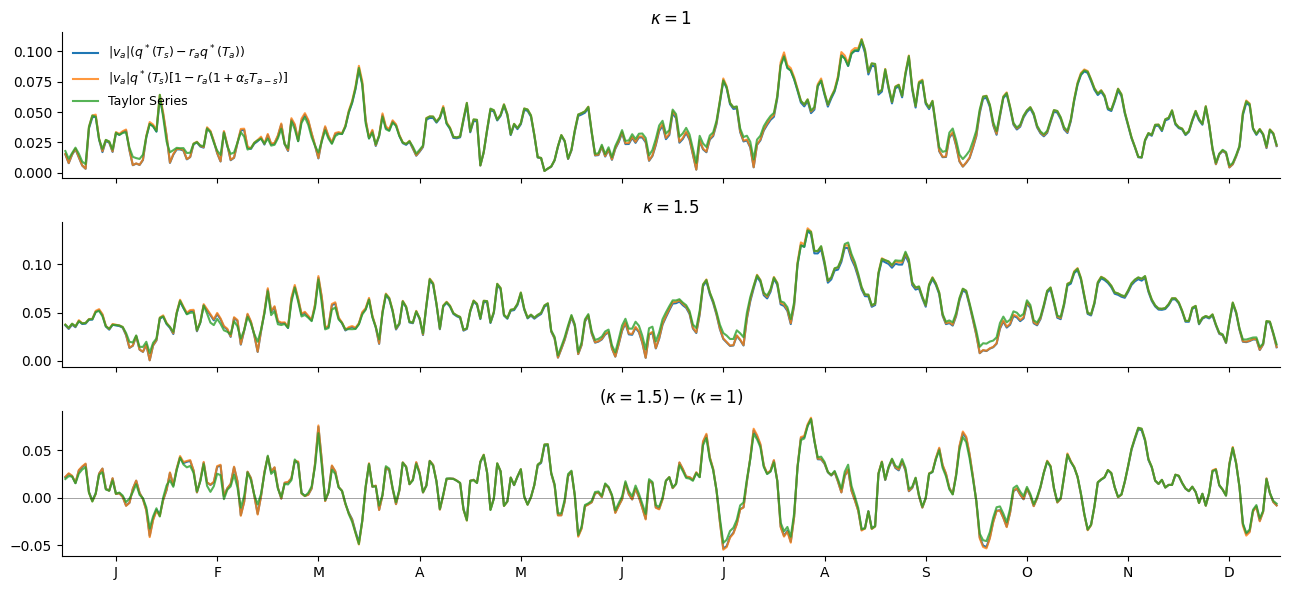

In [192]:
alpha_s = [clausius_clapeyron_factor(ds_single_loc[i].t_surf, p_surface) for i in range(n_exp)]
q_sat_s = [sphum_sat(ds_single_loc[i].t_surf, p_surface) for i in range(n_exp)]
r_a = [ds_single_loc[i].sphum/sphum_sat(ds_single_loc[i].temp, p_low_level) for i in range(n_exp)]
temp_diff = [ds_single_loc[i].temp - ds_single_loc[i].t_surf for i in range(n_exp)]
lh_mean = [0, 0]
lh_taylor_terms = [0, 0]
for i in range(n_exp):
    lh_mean[i], lh_taylor_terms[i], _ = get_lh_taylor_decomp(ds_single_loc[i])

fig, ax = plt.subplots(3,1, figsize=(13, 6), sharex=True)
for i in range(n_exp):
    ax[i].spines[['top', 'right']].set_visible(False)
    ax[i].plot(ds_single_loc[0].time-0.5, wind_speed[i] * sphum_diff[i], label='$|v_a|(q^*(T_s) - r_aq^*(T_a))$')
    ax[i].plot(ds_single_loc[0].time-0.5, wind_speed[i] * q_sat_s[i] * (1 - r_a[i] * (1+temp_diff[i] * alpha_s[i])), alpha=0.8,
        label='$|v_a|q^*(T_s)[1 - r_a(1 + \\alpha_s T_{a-s})]$')
    ax[i].plot(ds_single_loc[0].time-0.5, lh_mean[i] + sum(lh_taylor_terms[i].values()), alpha=0.8, label='Taylor Series')
ax[2].spines[['top', 'right']].set_visible(False)
ax[2].plot(ds_single_loc[0].time-0.5, wind_speed[1] * sphum_diff[1] - wind_speed[0] * sphum_diff[0])
ax[2].plot(ds_single_loc[0].time-0.5, wind_speed[1] * q_sat_s[1] * (1 - r_a[1] * (1+temp_diff[1] * alpha_s[1])) -
           wind_speed[0] * q_sat_s[0] * (1 - r_a[0] * (1+temp_diff[0] * alpha_s[0])), alpha=0.8)
ax[2].plot(ds_single_loc[0].time-0.5, lh_mean[1] + sum(lh_taylor_terms[1].values()) -
           (lh_mean[0] + sum(lh_taylor_terms[0].values())), alpha=0.8)
ax[2].hlines(0,-15,370, color='k', linewidth=0.5, alpha=0.5)

ax[0].set_title(f"$\kappa = {tau_lw[0]}$")
ax[1].set_title(f"$\kappa = {tau_lw[1]}$")
ax[2].set_title(f"$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$")
ax[0].legend(fontsize=9, frameon=False)
ax[0].set_xlim(-1,360)
ax[0].set_xticks(*month_ticks)
plt.tight_layout()

### Latent Heat Change with Warming

The green line in the bottom plot above shows the following equation of latent heat evaluated at the larger optical depth, minus the same equation evaluated at the smaller optical depth.

$$LH \approx |\overline{v_a}|q^*(\overline{T_s})\bigg(1 - \overline{r_a}(1 + \overline{\alpha_s} \overline{T_{a-s}})\bigg) + \mu_{v_a}\Delta v_a + \mu_{r_a}\Delta r_a + \mu_{T_{a-s}} \Delta T_{a-s} +
\mu_{T_s} \Delta T_s + \frac{1}{2}\mu_{T^2_s} \Delta T^2_s  + \mu_{T_sv_a} \Delta T_s \Delta v_a$$

We can split this equation up into the mean latent heat, $\overline{LH}$, and the seasonal variation from this mean, $\Delta LH$:
$$\overline{LH} = |\overline{v_a}|q^*(\overline{T_s})\bigg(1 - \overline{r_a}(1 + \overline{\alpha_s} \overline{T_{a-s}})\bigg)$$
$$\Delta LH = \mu_{v_a}\Delta v_a + \mu_{r_a}\Delta r_a + \mu_{T_{a-s}} \Delta T_{a-s} +
\mu_{T_s} \Delta T_s + \frac{1}{2}\mu_{T^2_s} \Delta T^2_s  + \mu_{T_sv_a} \Delta T_s \Delta v_a$$

Starting from these equations, we can perform another taylor series expansion to indicate what variables most explain the changes to $\overline{LH}$ and $\Delta LH$ with warming.

#### Changes to Mean
Mean latent heat can only be changed by changes to the mean quantities i.e.

$$\delta \overline{LH} \approx \gamma_{v_a}\delta \overline{v_a} + \gamma_{r_a}\delta \overline{r_a} +
\gamma_{T_{a-s}} \delta \overline{T_{a-s}} + \gamma_{T_s} \Delta \overline{T_s} + \frac{1}{2}\gamma_{T^2_s} \delta \overline{T_s}^2  +
\gamma_{T_sv_a} \delta \overline{T_s} \delta \overline{v_a}$$

Where the $\gamma$ terms represent the taylor coefficients evaluated at the colder climate i.e. $\gamma_{T_s} = \frac{\partial \overline{LH}}{\partial \overline{T_s}}$.

The $\delta$ terms reflect the change with warming i.e. $\delta \overline{T_s} = \overline{T_s}(\kappa^{warm}) -
\overline{T_s}(\kappa^{cold})$.

#### Changes to the Seasonal Variation
Given the equation for $\Delta LH$ above, changes with warming to the seasonal cycle arise from changes to the mean quantities and to changes in the seasonal variations of the quantities i.e.

$$\delta \Delta LH \approx \mu_{v_a}\delta\Delta v_a + \mu_{r_a}\delta\Delta r_a + \mu_{T_{a-s}} \delta\Delta T_{a-s} +
(\mu_{T_s} + \mu_{T^2_s}\Delta T_s + \mu_{T_sv_a}\Delta v_a)\delta\Delta T_s + \frac{1}{2}\mu_{T^2_s} \delta\Delta T^2_s  +
\mu_{T_sv_a} \delta\Delta T_s \delta\Delta v_a +\\
\lambda_{\overline{T_s}}\delta \overline{T_s} + \lambda_{\overline{v_a}}\delta \overline{v_a} +
\lambda_{\overline{r_a}}\delta \overline{r_a} +\lambda_{\overline{T_{a-s}}}\delta \overline{T_{a-s}} +
\lambda_{\bar{T_s}\bar{v_a}}\delta \overline{T_s}\delta \overline{v_a} +\\
\lambda_{\overline{T_s}\Delta v_a}\delta \overline{T_s}\delta \Delta v_a +
\lambda_{\Delta T_s \overline{v_a}}\delta \Delta T_s\delta \overline{v_a} +
\lambda_{\overline{T_s}\Delta T_s}\delta \overline{T_s}\delta \Delta T_s
$$

Where the $\lambda$ terms represent the taylor coefficients evaluated at the colder climate i.e. $\lambda_{\overline{T_s}} = \frac{\partial \Delta LH}{\partial \overline{T_s}}$ and $\lambda_{\Delta{T_s}} = \frac{\partial \Delta LH}{\partial \Delta T_s} =
(\mu_{T_s} + \mu_{T^2_s}\Delta T_s + \mu_{T_sv_a}\Delta v_a)$.

I split the equation across 3 lines, the first line represents changes to the seasonal variation. The second line represents changes to the mean quantities. The third line gives the non-linear cross terms. The terms I have included is somewhat arbitrary, but was mainly done on the basis of the algebra being useful. I.e. I didn't include terms where I had to compute $\partial \mu_{T^2_s} / \partial T_s$.


In [193]:
# Get the taylor series contributions to the change in mean latent heat
delta_lh_mean_taylor_coefs = get_lh_taylor_decomp(ds_single_loc[0])[2]
delta_mean = {'temp_s': np.mean(ds_single_loc[1].t_surf - ds_single_loc[0].t_surf),
              'wind': np.mean(wind_speed[1] - wind_speed[0]),
              'r_a': np.mean(r_a[1] - r_a[0]),
              'temp_diff': np.mean(temp_diff[1] - temp_diff[0]),
              'lh': lh_mean[1] - lh_mean[0]}
delta_lh_mean_taylor_terms = {}
for var in ['temp_s', 'wind', 'r_a', 'temp_diff']:
    delta_lh_mean_taylor_terms[var] = delta_lh_mean_taylor_coefs[var] * delta_mean[var]
delta_lh_mean_taylor_terms['temp_s_squared'] = delta_lh_mean_taylor_coefs['temp_s_squared'] * delta_mean['temp_s']**2
delta_lh_mean_taylor_terms['wind_temp_s'] = delta_lh_mean_taylor_coefs['wind_temp_s'] * delta_mean['temp_s'] * delta_mean['wind']
delta_lh_mean_taylor_terms['r_temp_s'] = delta_lh_mean_taylor_coefs['r_temp_s'] * delta_mean['temp_s'] * delta_mean['r_a']
delta_lh_mean_taylor_terms['wind_r'] = delta_lh_mean_taylor_coefs['wind_r'] * delta_mean['wind'] * delta_mean['r_a']
delta_lh_mean_taylor_terms['tempdiff_temp_s'] = delta_lh_mean_taylor_coefs['tempdiff_temp_s'] * delta_mean['temp_s'] *\
                                                delta_mean['temp_diff']
delta_lh_mean_taylor_terms['wind_tempdiff'] = delta_lh_mean_taylor_coefs['wind_tempdiff'] * delta_mean['wind'] * delta_mean['temp_diff']

# Compute the change in mean latent heat as given by summing up all taylor series terms
delta_mean['lh_from_taylor'] = sum(delta_lh_mean_taylor_terms.values())

In [194]:
# Get the taylor series contributions to the change in seasonal variation of latent heat
def get_lh_taylor_decomp_season(ds_cold, ds_warm, p_low=p_low_level, p_s=p_surface, mean_axis=None):
    # This gets taylor components for change with warming of the seasonal variation of latent heat
    # Compute the mean variables from the reference climate
    v_mean = np.mean(np.sqrt(ds_cold.vcomp**2 + ds_cold.ucomp**2), axis=mean_axis)
    temp_s_mean = np.mean(ds_cold.t_surf, axis=mean_axis)
    r_a = ds_cold.sphum/sphum_sat(ds_cold.temp, p_low)
    r_a_mean = np.mean(r_a, axis=mean_axis)
    temp_diff = ds_cold.temp - ds_cold.t_surf
    temp_diff_mean = np.mean(temp_diff, axis=mean_axis)

    # Compute the difference to the mean in the reference climate i.e. the seasonal variation
    season_diff = {'wind': np.sqrt(ds_cold.vcomp**2 + ds_cold.ucomp**2) - v_mean,
                  'temp_s': ds_cold.t_surf - temp_s_mean,
                  'r_a': r_a - r_a_mean,
                  'temp_diff': temp_diff - temp_diff_mean}
    season_diff['wind_temp_s'] = season_diff['wind'] * season_diff['temp_s']

    # Compute the change with warming in the mean quantities
    delta_mean = {'wind': np.mean(np.sqrt(ds_warm.vcomp**2 + ds_warm.ucomp**2), axis=mean_axis) - v_mean,
                  'temp_s': np.mean(ds_warm.t_surf, axis=mean_axis) - temp_s_mean,
                  'r_a': np.mean(ds_warm.sphum/sphum_sat(ds_warm.temp, p_low), axis=mean_axis) - r_a_mean,
                  'temp_diff': np.mean(ds_warm.temp - ds_warm.t_surf, axis=mean_axis) - temp_diff_mean}
    # Compute the change with warming in the seasonal variation of the quantities
    delta_season = {'temp_s': ds_warm.t_surf - ds_cold.t_surf - delta_mean['temp_s'],
                    'wind': np.sqrt(ds_warm.vcomp**2 + ds_warm.ucomp**2) - np.sqrt(ds_cold.vcomp**2 + ds_cold.ucomp**2)
                            - delta_mean['wind'],
                    'r_a': ds_warm.sphum/sphum_sat(ds_warm.temp, p_low) - r_a - delta_mean['r_a'],
                    'temp_diff': ds_warm.temp - ds_warm.t_surf - temp_diff - delta_mean['temp_diff']}

    # quantities used in taylor expansion
    q_sat_s_mean = sphum_sat(temp_s_mean, p_s)
    alpha_s_mean = clausius_clapeyron_factor(temp_s_mean, p_s)
    lh_taylor_mean_coefs = get_lh_taylor_decomp(ds_cold, p_low, p_s, mean_axis)[2]

    # IMPORTANT - must have delta terms as first term in product to ensure correct shape when include latitude and longitude
    # I.e. when using the mean_axis variable
    lh_taylor_coefs = {'season': {}, 'mean': {}, 'mixed': {}}
    # First compute change in seasonal variation of latent heat which is due to change in the seasonal variation of the variables
    lh_taylor_coefs['season']['temp_s'] = delta_season['temp_s'] * (lh_taylor_mean_coefs['temp_s'] +
                                                                2 * lh_taylor_mean_coefs['temp_s_squared'] * season_diff['temp_s'] +
                                                                lh_taylor_mean_coefs['wind_temp_s'] * season_diff['wind'])
    lh_taylor_coefs['season']['wind'] = delta_season['wind'] * (lh_taylor_mean_coefs['wind'] +
                                                                lh_taylor_mean_coefs['wind_temp_s'] * season_diff['temp_s'])
    lh_taylor_coefs['season']['r_a'] = delta_season['r_a'] * lh_taylor_mean_coefs['r_a']
    lh_taylor_coefs['season']['temp_diff'] = delta_season['temp_diff'] * lh_taylor_mean_coefs['temp_diff']
    lh_taylor_coefs['season']['temp_s_squared'] = delta_season['temp_s']**2 * lh_taylor_mean_coefs['temp_s_squared']
    lh_taylor_coefs['season']['wind_temp_s'] = delta_season['temp_s'] * delta_season['wind'] * lh_taylor_mean_coefs['wind_temp_s']

    # Second, compute change in seasonal variation of latent heat which is due to change in the mean value of the variables
    # Start with taylor expansion of latent heat to give seasonal variation
    # Then need to do another taylor expansion of this to give change in seasonal variation with warming

    # MEAN TEMP
    # mean temperature is everywhere in the taylor expansion hence lots of terms below
    d_lh_d_wind_temp =  lh_taylor_mean_coefs['wind_temp_s']
    d_lh_d_r_temp = - v_mean * q_sat_s_mean * alpha_s_mean * (
            1 + (temp_diff_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2))
    d_lh_d_tempdiff_temp = - v_mean * q_sat_s_mean * alpha_s_mean * (
            (r_a_mean / temp_s_mean) * (alpha_s_mean * temp_s_mean - 2))
    d_lh_d_temp_temp = 2 * lh_taylor_mean_coefs['temp_s_squared']
    d_lh_d_wind_temp_temp =  d_lh_d_temp_temp / v_mean
    d_lh_d_temp_wind_r = lh_taylor_mean_coefs['r_temp_s']/v_mean
    d_lh_d_wind_r = lh_taylor_mean_coefs['wind_r']
    d_lh_d_wind_tempdiff = lh_taylor_mean_coefs['wind_tempdiff']
    d_lh_d_temp_wind_tempdiff = lh_taylor_mean_coefs['tempdiff_temp_s'] / v_mean

    lh_taylor_coefs['mean']['temp_s'] = delta_mean['temp_s'] * (
            season_diff['wind'] * d_lh_d_wind_temp + season_diff['r_a'] * d_lh_d_r_temp + season_diff['temp_diff'] * d_lh_d_tempdiff_temp +
            season_diff['temp_s'] * d_lh_d_temp_temp + season_diff['temp_s'] * season_diff['wind'] * d_lh_d_wind_temp_temp)

    # MEAN WIND
    lh_taylor_coefs['mean']['wind'] = delta_mean['wind']/v_mean * (
            season_diff['r_a'] * lh_taylor_mean_coefs['r_a'] + season_diff['temp_diff'] * lh_taylor_mean_coefs['temp_diff'] +
            season_diff['temp_s'] * lh_taylor_mean_coefs['temp_s'] + season_diff['temp_s']**2 * lh_taylor_mean_coefs['temp_s_squared'])

    # MEAN RH
    d_lh_d_tempdiff_r = lh_taylor_mean_coefs['temp_diff']/r_a_mean
    lh_taylor_coefs['mean']['r_a'] = delta_mean['r_a'] * (season_diff['temp_s'] * d_lh_d_r_temp + season_diff['wind'] * d_lh_d_wind_r +
                                                          season_diff['temp_diff'] * d_lh_d_tempdiff_r)

    # MEAN TEMP_DIFF
    lh_taylor_coefs['mean']['temp_diff'] = delta_mean['temp_diff'] * (season_diff['temp_s'] * d_lh_d_tempdiff_temp +
                                                                      season_diff['wind'] * d_lh_d_wind_tempdiff +
                                                                      season_diff['r_a'] * d_lh_d_tempdiff_r)

    # MEAN WIND and TEMP_S NONLINEAR
    lh_taylor_coefs['mean']['wind_temp_s'] = delta_mean['wind'] * delta_mean['temp_s'] / v_mean * (
        season_diff['r_a'] * d_lh_d_r_temp + season_diff['temp_diff'] * d_lh_d_tempdiff_temp + season_diff['temp_s'] * d_lh_d_temp_temp)

    # Lastly, compute change in seasonal variation of latent heat which is due to nonlinear combination of changes in the mean and
    # seasonal values of the variables
    lh_taylor_coefs['mixed']['mean_temp_seasonal_wind'] = delta_mean['temp_s'] * delta_season['wind'] * (
            d_lh_d_wind_temp + season_diff['temp_s'] * d_lh_d_wind_temp_temp)
    lh_taylor_coefs['mixed']['mean_wind_seasonal_temp'] = delta_mean['wind'] * delta_season['temp_s'] / v_mean * (
        lh_taylor_mean_coefs['temp_s'] + 2 * season_diff['temp_s'] * lh_taylor_mean_coefs['temp_s_squared']
    )
    lh_taylor_coefs['mixed']['mean_temp_seasonal_temp'] = delta_mean['temp_s'] * delta_season['temp_s'] * (
        d_lh_d_temp_temp + season_diff['wind'] * d_lh_d_wind_temp_temp
    )
    lh_taylor_coefs['mixed']['mean_r_seasonal_wind'] = delta_mean['r_a'] * delta_season['wind'] * (
        d_lh_d_wind_r + season_diff['temp_s'] * d_lh_d_temp_wind_r
    )
    lh_taylor_coefs['mixed']['mean_r_seasonal_temp'] = delta_mean['r_a'] * delta_season['temp_s'] * (
        d_lh_d_r_temp + season_diff['wind'] * d_lh_d_temp_wind_r    # ignore contribution from temp_squared as too complicated
    )
    lh_taylor_coefs['mixed']['mean_tempdiff_seasonal_wind'] = delta_mean['temp_diff'] * delta_season['wind'] * (
        d_lh_d_wind_tempdiff + season_diff['temp_s'] * d_lh_d_temp_wind_tempdiff
    )
    lh_taylor_coefs['mixed']['mean_tempdiff_seasonal_temp'] = delta_mean['temp_diff'] * delta_season['temp_s'] * (
        d_lh_d_tempdiff_temp + season_diff['wind'] * d_lh_d_temp_wind_tempdiff  # ignore contribution from temp_squared as too complicated
    )


    return lh_taylor_coefs

In [195]:
# Change in the seasonal variation of each of the variables going into latent heat
delta_season = {'temp_s': ds_single_loc[1].t_surf - ds_single_loc[0].t_surf - delta_mean['temp_s'],
                'wind': wind_speed[1] - wind_speed[0] - delta_mean['wind'],
                'r_a': r_a[1] - r_a[0] - delta_mean['r_a'],
                'temp_diff': temp_diff[1] - temp_diff[0] - delta_mean['temp_diff'],
                'lh': sum(lh_taylor_terms[1].values()) - sum(lh_taylor_terms[0].values())}

delta_lh_season_taylor_terms = get_lh_taylor_decomp_season(ds_single_loc[0], ds_single_loc[1])
delta_season['lh_from_taylor'] = sum(delta_lh_season_taylor_terms['season'].values())+ \
                                 sum(delta_lh_season_taylor_terms['mean'].values()) + \
                                 sum(delta_lh_season_taylor_terms['mixed'].values())

### Taylor Series Sanity Check
Below I check that the taylor series expansion for changes in latent heat with warming outlined above give a decent approximation.
The blue dot gives $\delta \overline{LH}$ and the orange dot gives the taylor series approximation for it.
The blue line gives $\delta \Delta LH$ and the orange line gives the taylor series approximation for it.

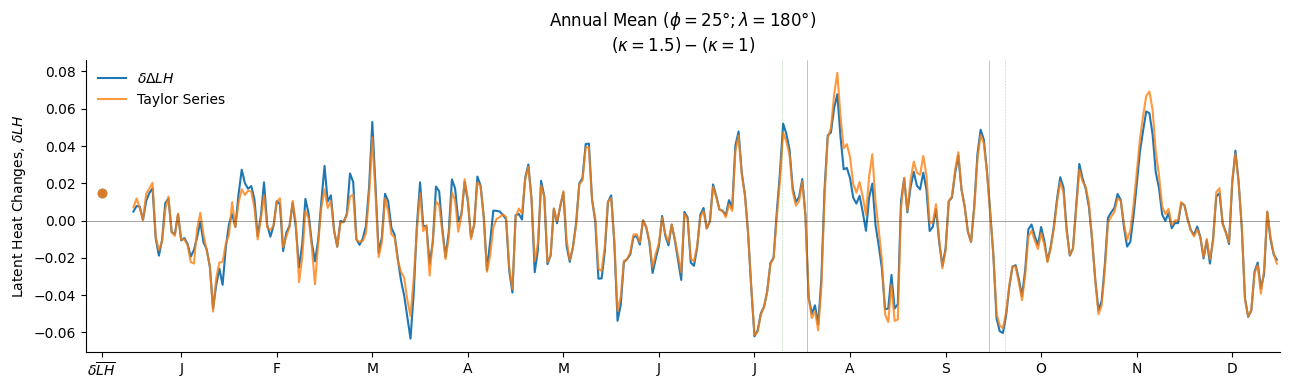

In [196]:
fig, ax = plt.subplots(1,1, figsize=(13, 4))
ax.spines[['top', 'right']].set_visible(False)
ax.scatter(-10, delta_mean['lh'])
ax.scatter(-10, delta_mean['lh_from_taylor'], alpha=0.8)
ax.plot(ds_single_loc[0].time-0.5, delta_season['lh'], label='$\delta \Delta LH$')
ax.plot(ds_single_loc[0].time-0.5, delta_season['lh_from_taylor'], label='Taylor Series', alpha=0.8)
ax.set_xticks(np.append(month_ticks[0], -10), np.append(month_ticks[1], '$\delta \overline{LH}$'))
ax.set_xlim(-15,360)
ax.hlines(0,-15,370, color='k', linewidth=0.5, alpha=0.5)
ax.set_title(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)\n"
             f"$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$")
ax.legend(frameon=False)

ylim = ax.get_ylim()
for j in range(n_exp):
    ax.vlines([max_summer_time[j], max_winter_time[j]], *ylim, color='g', alpha=0.6, linewidth=0.4,
                  linestyles='-' if j==0 else ':')
ax.set_ylim(ylim)
ax.set_ylabel('Latent Heat Changes, $\delta LH$')
plt.tight_layout()

### Latent Heat Change Decomposition
With warming, the average upward latent heat flux increases i.e. you get more cooling. The seasonal variation is less clear. Below, I investigate the different contributions to this change.

#### Tropics
In the tropics ($\phi=15\degree; \lambda=180\degree$), the first figure shows that the temperature changes dominate the change in the mean latent heat, $\delta \overline{LH}$.

The second figure shows that the seasonal variation, $\delta \Delta LH$, is mainly dominated by changes to the seasonal variation of the wind speed, $\delta \Delta |v_a|$. Other significant contributions are from changes to the mean temperature (blue line in the top plot), $\delta \overline{T_s}$, and the mixed term (blue line in bottom plot) $\delta \overline{T_s} \delta \Delta |v_a|$.

#### Extratropics
In the extratropics ($\phi=60\degree; \lambda=180\degree$), the first figure shows that the temperature and wind changes dominate the change in the mean latent heat, $\delta \overline{LH}$.

The second figure shows that the seasonal variation, $\delta \Delta LH$, is mainly dominated by changes to the seasonal variation of the wind speed, $\delta \Delta |v_a|$. Other significant contributions are from changes to the mean temperature (blue line in the top plot), $\delta \overline{T_s}$, and the mixed term (blue line in bottom plot) $\delta \overline{T_s} \delta \Delta |v_a|$.

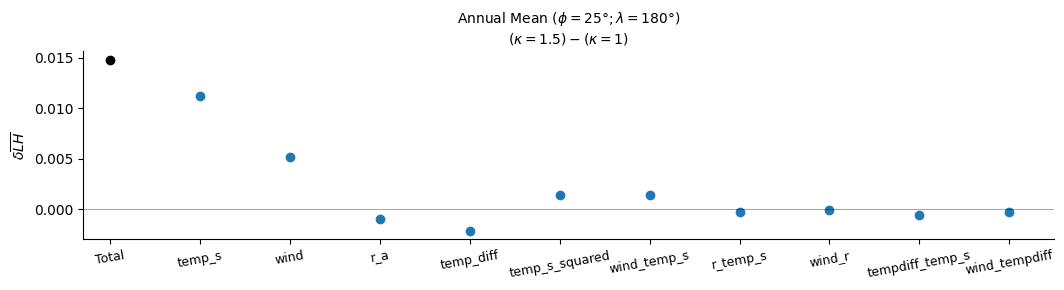

In [197]:
fig, ax = plt.subplots(1,1, figsize=(11, 3))
ax.spines[['top', 'right']].set_visible(False)
ax.scatter(np.arange(len(delta_lh_mean_taylor_terms)), delta_lh_mean_taylor_terms.values())
ax.scatter(-1, delta_mean['lh'], color='k')
ax.set_xticks(np.arange(-1, len(delta_lh_mean_taylor_terms)), ['Total']+list(delta_lh_mean_taylor_terms.keys()),
              rotation=10, fontsize=9)
ax.set_title(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)\n"
             f"$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$", fontsize=10)
ax.set_ylabel('$\delta \overline{LH}$')
ax.set_xlim(-1.3,len(delta_lh_mean_taylor_terms)-0.5)
ax.hlines(0,-20,370, color='k', linewidth=0.5, alpha=0.5)
plt.tight_layout()

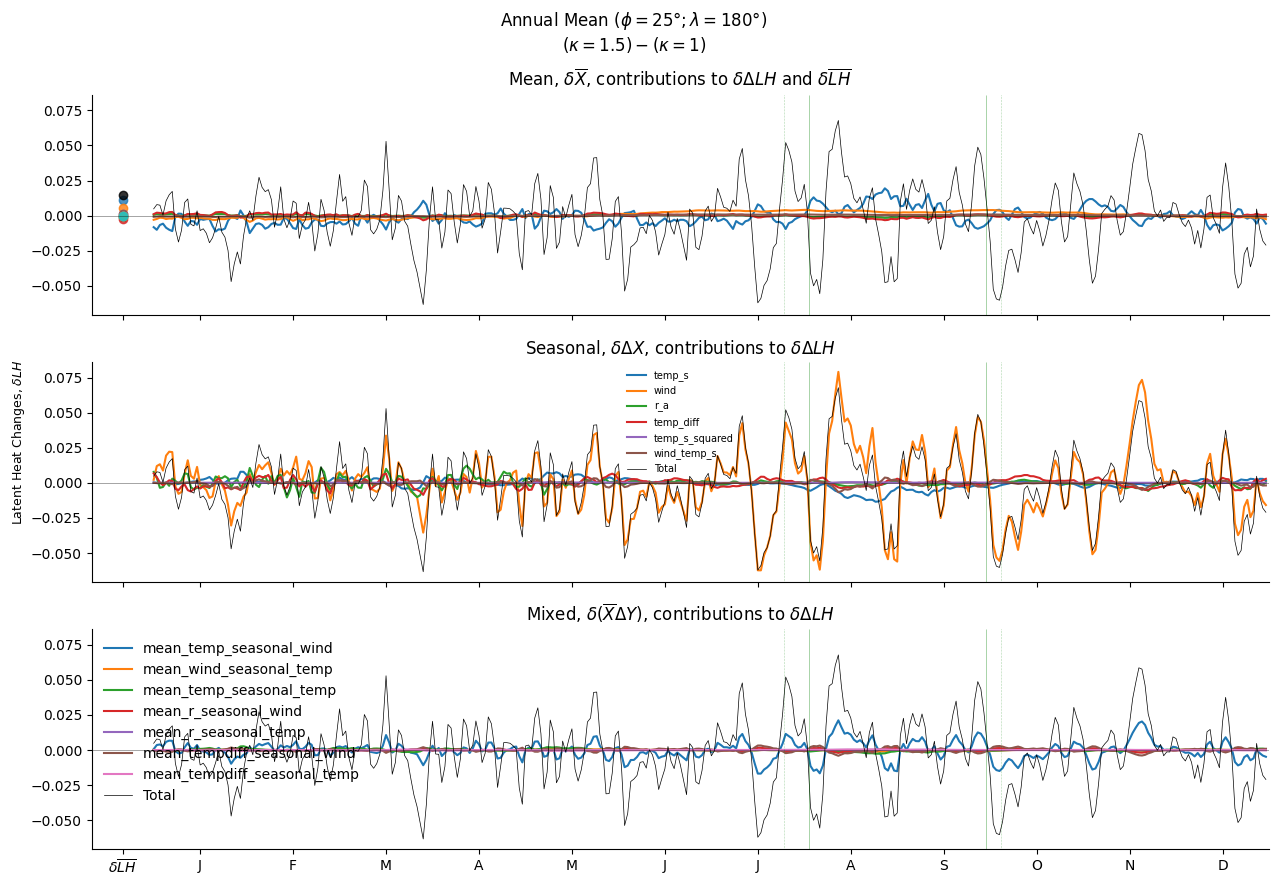

In [198]:
fig, ax = plt.subplots(3,1, figsize=(13, 9), sharex=True, sharey=True)
for i, key in enumerate(delta_lh_mean_taylor_terms):
    ax[0].scatter(-10, delta_lh_mean_taylor_terms[key], label=key, alpha=0.8, color=default_colors[i])
    if key in delta_lh_season_taylor_terms['mean'].keys():
        ax[0].plot(ds_single_loc[0].time-0.5, delta_lh_season_taylor_terms['mean'][key], color=default_colors[i])
ax[0].scatter(-10, delta_mean['lh'], color='k', alpha=0.8, label='Total')
ax[0].set_title('Mean, $\delta \overline{X}$, contributions to $\delta \Delta LH$ and $\delta \overline{LH}$')

for key in delta_lh_season_taylor_terms['season'].keys():
    ax[1].plot(ds_single_loc[0].time-0.5, delta_lh_season_taylor_terms['season'][key], label=key)
ax[1].set_title('Seasonal, $\delta \Delta X$, contributions to $\delta \Delta LH$')
for key in delta_lh_season_taylor_terms['mixed'].keys():
    ax[2].plot(ds_single_loc[0].time-0.5, delta_lh_season_taylor_terms['mixed'][key], label=key)
ax[2].set_title('Mixed, $\delta (\overline{X}\Delta Y)$, contributions to $\delta \Delta LH$')

for ax_use in ax:
    ax_use.spines[['top', 'right']].set_visible(False)
    ax_use.plot(ds_single_loc[0].time-0.5, delta_season['lh'], color='k', lw=0.5, label='Total')
    ax_use.hlines(0,-20,370, color='k', linewidth=0.5, alpha=0.5)
    ylim = ax_use.get_ylim()
    for j in range(n_exp):
        ax_use.vlines([max_summer_time[j], max_winter_time[j]], *ylim, color='g', alpha=0.6, linewidth=0.4,
                      linestyles='-' if j==0 else ':')
    ax_use.set_ylim(ylim)

ax[1].legend(frameon=False, fontsize=7)
ax[2].legend(frameon=False)
ax[0].set_xticks(np.append(month_ticks[0], -10), np.append(month_ticks[1], '$\delta \overline{LH}$'))
ax[0].set_xlim(-20,360)
fig.supylabel('Latent Heat Changes, $\delta LH$', fontsize=9)
fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)\n"
             f"$(\kappa = {tau_lw[1]}) - (\kappa = {tau_lw[0]})$")
plt.tight_layout()

## Global Analysis
Below I look at the date of the hottest day at each latitude and longitude, and investigate which fluxes are the dominant warming and cooling mechanism.

### Date of Hottest Day
First, I show the date of the hottest day of the year and the delay to the peak in shortwave radiation at that location. In the right plot, red means that the hottest day occurs after the peak in insolation.

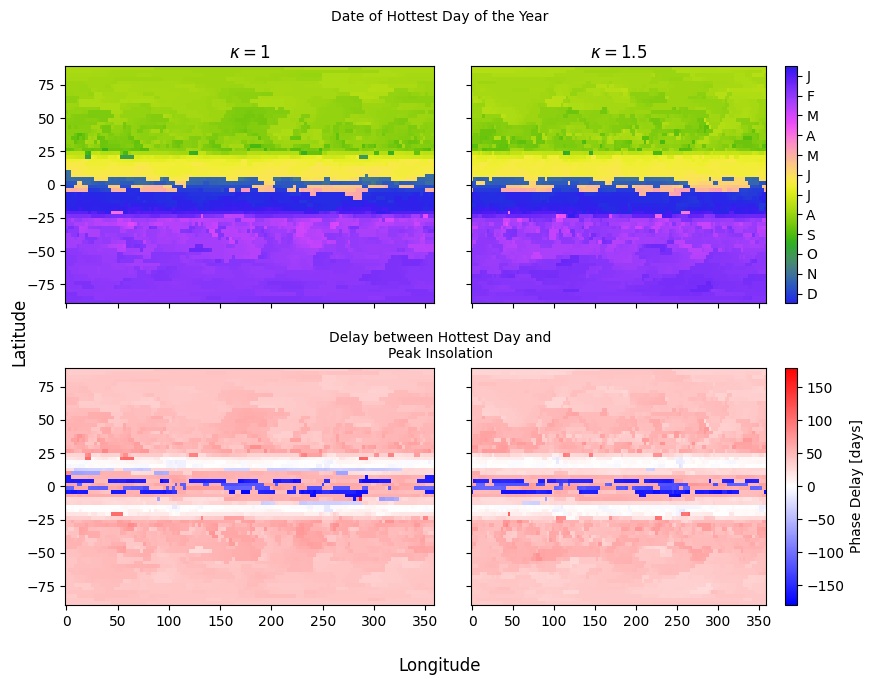

In [199]:
hottest_day_ind = [ds_global[i].t_surf.argmax(axis=0) for i in range(n_exp)]
phase_delay = np.asarray([np.asarray((ds_global[i].time[hottest_day_ind[i]] -
                                      ds_global[i].time[ds_global[i].swdn_sfc.argmax(axis=0)])) % 360 for i in range(n_exp)])
delta_hottest_day = np.asarray(ds_global[1].time[hottest_day_ind[1]] - ds_global[0].time[hottest_day_ind[0]])

# Correct due to cyclic nature of the calendar
phase_delay[phase_delay>180] -= 360
delta_hottest_day[delta_hottest_day>180] -= 360

fig, ax = plt.subplots(n_exp,2, figsize=(10, 7), sharex=True, sharey=True)
for i in range(n_exp):
    im  = ax[0, i].pcolormesh(ds_global[0].lon, ds_global[0].lat, ds_global[i].time[hottest_day_ind[i]],
                              cmap=colorcet.cm.colorwheel, vmin=0, vmax=360)
    im2  = ax[1, i].pcolormesh(ds_global[0].lon, ds_global[0].lat, phase_delay[i], cmap='bwr', vmin=-180, vmax=180)
    ax[0, i].set_title(f'$\kappa = {tau_lw[i]}$')
cbar2 = plt.colorbar(im2, ax=ax[1, 1], label='Phase Delay [days]')
cbar = plt.colorbar(im, ticks=month_ticks[0], ax=ax[0, 1])
cbar.ax.set_yticklabels(month_ticks[1])
cbar.ax.invert_yaxis()
fig.supxlabel('Longitude')
fig.supylabel('Latitude', x=0.07)
plt.figtext(0.5, 0.95, 'Date of Hottest Day of the Year', ha='center', va='center')
plt.subplots_adjust(hspace=0.27)
plt.subplots_adjust(wspace=0.1)
plt.figtext(0.5, 0.48, 'Delay between Hottest Day and\nPeak Insolation', ha='center', va='center');

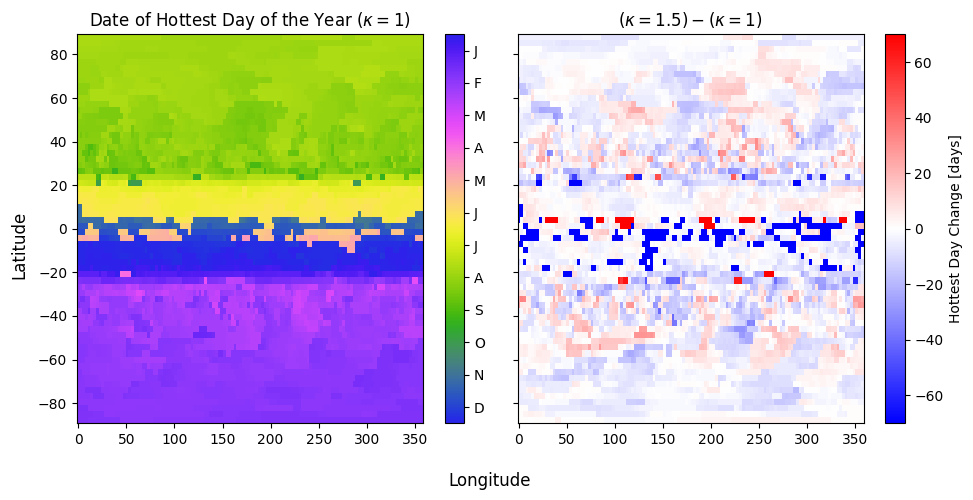

In [200]:
# Plot change in date of hottest day between simulations
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
im  = ax[0].pcolormesh(ds_global[0].lon, ds_global[0].lat, ds_global[0].time[hottest_day_ind[0]],
                     cmap=colorcet.cm.colorwheel, vmin=0, vmax=360)
cbar = plt.colorbar(im, ticks=month_ticks[0], ax=ax[0])
cbar.ax.set_yticklabels(month_ticks[1])
cbar.ax.invert_yaxis()
fig.supxlabel('Longitude')
fig.supylabel('Latitude')
ax[0].set_title(f'Date of Hottest Day of the Year ($\kappa={tau_lw[0]}$)')
im  = ax[1].pcolormesh(ds_global[0].lon, ds_global[0].lat, delta_hottest_day,
                     cmap='bwr', vmin=-70, vmax=70)
cbar = plt.colorbar(im, ax=ax[1], label='Hottest Day Change [days]')
ax[1].set_title(f'$(\kappa={tau_lw[1]}) - (\kappa={tau_lw[0]})$')
plt.tight_layout()

### Hottest day before and after central summer
The above plots are complicated by the fact, that in the tropics there are two peaks in temperature, one before central summer (1st August in Northern Hemisphere; 1st February in Southern Hemisphere) and one after central summer.

In the plots below, I show the difference to this summer date of the hottest day before and after it. At latitudes above around $25\degree$ the bottom plot goes white, indicating that we no longer have the double hottest day but only a single global maxima.

The most striking thing we see with warming is that there is a zonal strip at around $25\degree$ where the hottest day before central summer becomes even earlier (top right plot) and the hottest day after central summer becomes even later (bottom right plot). This indicates that the ITCZ migrates further north with warming so you get the double hottest day caused by the passing of the winds.


In [201]:
summer_day_nh = 8*30  # before August is summer
max_summer_time_global_nh = [-summer_day_nh +
                             ds_global[i].time[ds_global[i].time<summer_day_nh][ds_global[i].t_surf[
                                 ds_global[i].time<summer_day_nh].argmax(axis=0)] for i in range(n_exp)]
max_winter_time_global_nh = [-summer_day_nh +
                             ds_global[i].time[ds_global[i].time>=summer_day_nh][ds_global[i].t_surf[
                                 ds_global[i].time>=summer_day_nh].argmax(axis=0)] for i in range(n_exp)]

summer_day_sh = 2*30  # before February is summer
time_sh = np.asarray(ds_global[0].time).copy()
time_sh[time_sh > summer_day_nh] -= 360      # so december is considered part of summer below
time_sh = xr.DataArray(time_sh, dims=ds_global[0].time.dims, coords=ds_global[0].time.coords)
max_summer_time_global_sh = [-summer_day_sh +
                             time_sh[time_sh<summer_day_sh][ds_global[i].t_surf[time_sh<summer_day_sh].argmax(axis=0)]
                             for i in range(n_exp)]
max_winter_time_global_sh = [-summer_day_sh +
                             time_sh[time_sh>=summer_day_sh][ds_global[i].t_surf[time_sh>=summer_day_sh].argmax(axis=0)]
                             for i in range(n_exp)]
max_summer_time_global = [xr.concat([max_summer_time_global_sh[i].sel(lat=slice(-90,0)),
                                    max_summer_time_global_nh[i].sel(lat=slice(0,90))], dim='lat') for i in range(n_exp)]
max_winter_time_global = [xr.concat([max_winter_time_global_sh[i].sel(lat=slice(-90,0)),
                                    max_winter_time_global_nh[i].sel(lat=slice(0,90))], dim='lat') for i in range(n_exp)]

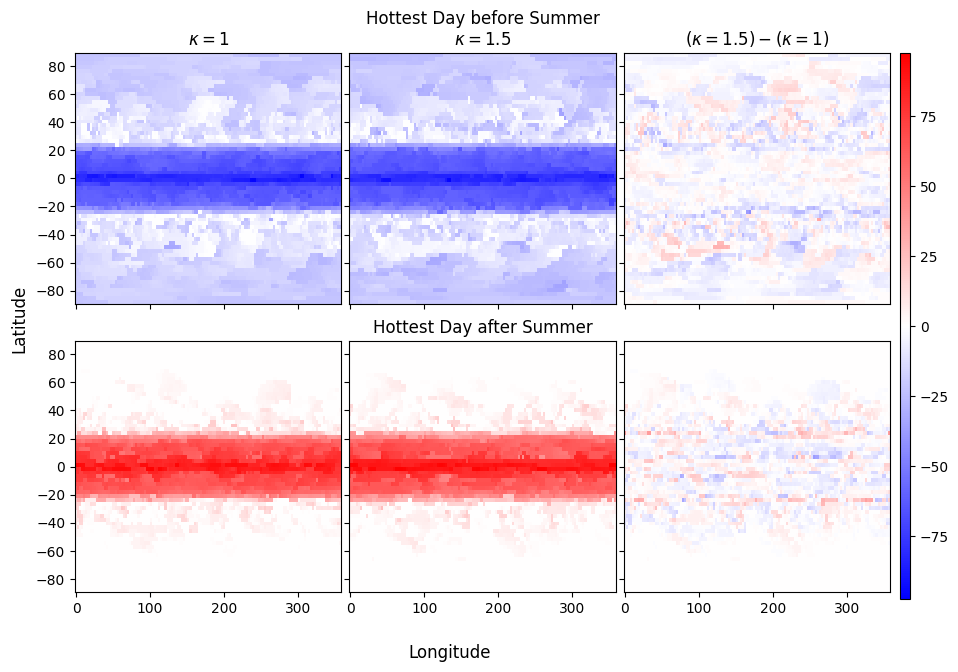

In [202]:
vmax = np.max([np.abs(np.asarray(max_summer_time_global)).max(), np.abs(np.asarray(max_winter_time_global)).max()])
fig, ax = plt.subplots(2,3, figsize=(10, 7), sharex=True, sharey=True)
for i in range(n_exp):
    ax[0, i].set_title(f'$\kappa={tau_lw[i]}$')
    im  = ax[0, i].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_summer_time_global[i],
                         cmap='bwr', vmin=-vmax, vmax=vmax)
    im  = ax[1, i].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_winter_time_global[i],
                         cmap='bwr', vmin=-vmax, vmax=vmax)
im  = ax[0, 2].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_summer_time_global[1]-max_summer_time_global[0],
                         cmap='bwr', vmin=-vmax, vmax=vmax)
im  = ax[1, 2].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_winter_time_global[1]-max_winter_time_global[0],
                         cmap='bwr', vmin=-vmax, vmax=vmax)
cbar_ax = fig.add_axes([0.95, 0.1, 0.01, 0.78])
plt.subplots_adjust(hspace=0.15, wspace=0.03, right=0.94)
ax[0, 0].set_title(f'$\kappa={tau_lw[0]}$')
ax[0, 1].set_title(f'Hottest Day before Summer\n$\kappa={tau_lw[1]}$')
ax[0, 2].set_title(f'$(\kappa={tau_lw[1]}) - (\kappa={tau_lw[0]})$')
ax[1, 1].set_title(f'Hottest Day after Summer')
fig.colorbar(im, cax=cbar_ax)
fig.supxlabel('Longitude')
fig.supylabel('Latitude', x=0.06);

### Dominant Heating and Cooling Mechanism
Below I sum up the surface flux terms in the 10 days proceeding the hottest day at each location. For each location, I plot the flux which is the maximum, to indicate the dominant heating mechanism.

I also sum up the flux terms in the 10 days after the hottest day at each location. For each location, I plot the flux which is minimum (most negative), to indicate the dominant cooling mechanism.

The striking thing is that latent heat provides the dominant heating mechanism at the tropics, while elsewhere it comes from the shortwave radiation. Equally, latent heat is the dominant cooling mechanism except for the poles and some of the tropics.

In [ ]:
# Get flux values for the hottest day of the year at each latitue and longitude
n_time, n_lat, n_lon = ds_global[0].swdn_sfc.shape
hottest_day_ind_flatten = np.ravel_multi_index([hottest_day_ind.to_numpy().flatten(), np.indices(hottest_day_ind.shape)[0].flatten(),
                                                np.indices(hottest_day_ind.shape)[1].flatten()], (n_time, n_lat, n_lon))

flux_sum_days = {'before': {}, 'after': {}}
for i, flux in enumerate([ds_global[0].swdn_sfc, ds_global[0].lwdn_sfc - ds_global[0].lwup_sfc,
                          -ds_global[0].flux_lhe, -ds_global[0].flux_t]):
    for key in flux_sum_days:
        flux_sum_days_all = sum_over_days((flux-flux.mean(axis=0))/ heat_capacity * day_seconds, n_day_sum, direction=key, axis=0)
        flux_sum_days[key][flux_names[i]] = flux_sum_days_all.flatten()[hottest_day_ind_flatten].reshape((n_lat, n_lon))

In [ ]:
# Initialise how to do categorical colour mapping - https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar
# Let's also design our color mapping: 1s should be plotted in blue, 2s in red, etc...
col_dict={0:"blue",
          1:"red",
          2:"orange",
          3:"green"}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(["Short Wave","Long Wave","Latent Heat","Sensible Heat"])
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

In [ ]:
max_heat_flux_ind = np.argmax(np.asarray([flux_sum_days['before'][flux] for flux in flux_sum_days['before']]), axis=0)
max_cool_flux_ind = np.argmin(np.asarray([flux_sum_days['after'][flux] for flux in flux_sum_days['before']]), axis=0)

# Show which flux provides dominant heating and cooling around hottest day
fig, ax = plt.subplots(1,2, figsize=(10, 4), sharex=True, sharey=True)
ax[0].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_heat_flux_ind, cmap=cm, norm=norm)
im = ax[1].pcolormesh(ds_global[0].lon, ds_global[0].lat, max_cool_flux_ind, cmap=cm, norm=norm)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
ax[0].set_title(f'Dominant Anomalous Heating in\n{n_day_sum} days preceeding hottest day', fontsize=11)
ax[1].set_title(f'Dominant Anomalous Cooling in\n{n_day_sum} days after hottest day', fontsize=11)
plt.tight_layout()

fig.subplots_adjust(right=0.9)
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cbar_ax = fig.add_axes([0.92, 0.09, 0.01, 0.85])
fig.colorbar(im, cax=cbar_ax, format=fmt, ticks=tickz)
cbar_ax.invert_yaxis()

### Individual Flux Contributions
Below I expand on the above plots to show the surface fluxes in the 10 days prior and after the hottest day.

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, flux in enumerate(flux_sum_days['before']):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, flux_sum_days['before'][flux], vmin=-8, vmax=8, cmap='bwr')
    ax[i].set_title(flux)
fig.suptitle(f'Surface Fluxes in {n_day_sum} days leading up to hottest day')
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.76])
fig.colorbar(im, cax=cbar_ax, label=f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(10, 5), sharex=True, sharey=True)
ax = ax.flatten()
for i, flux in enumerate(flux_sum_days['after']):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, flux_sum_days['after'][flux], vmin=-8, vmax=8, cmap='bwr')
    ax[i].set_title(flux)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Surface Fluxes in {n_day_sum} days after the hottest day')
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.01, 0.76])
fig.colorbar(im, cax=cbar_ax, label=f'{n_day_sum} Day Anomalous\nTemperature Tendency [K/{n_day_sum} days]')

### Latent Heat Decomposition
From the above plots, it seems that latent heat is important as both a heating and cooling mechanism. Below, I investigate what is causing these latent heat changes.

Here, it is clear that anomalous winds are the dominant cause of the latent heat warming in the tropics. In all regions, the dominant latent cooling is provided by an increase to the temperature.

In the tropics, you also get a large difference between the surface and near-surface temperature, which adds significantly to the cooling.

In [ ]:
lh_taylor_terms_global = get_lh_taylor_decomp(ds_global[0], mean_axis=0)[1]
lh_taylor_terms_global['temp_total'] = lh_taylor_terms_global['temp_s'] + lh_taylor_terms_global['temp_s_squared']
keys_plot = ['temp_s', 'temp_total', 'wind','wind_temp_s', 'r_a', 'temp_diff']
lh_taylor_sum_days = {'before': {}, 'after': {}}
for i, flux in enumerate(keys_plot):
    for key in lh_taylor_sum_days:
        # flux_sum_days_all = np.asarray(lh_taylor_terms_global[flux])
        flux_sum_days_all = sum_over_days(lh_taylor_terms_global[flux], n_day_sum, direction=key, axis=0)
        lh_taylor_sum_days[key][keys_plot[i]] = flux_sum_days_all.flatten()[hottest_day_ind_flatten].reshape((n_lat, n_lon))

In [ ]:
vmax = np.max([np.abs(var).max() for var in lh_taylor_sum_days['before'].values()])
fig, ax = plt.subplots(3,2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i, key in enumerate(keys_plot):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_taylor_sum_days['before'][key], cmap='bwr_r', vmin=-vmax, vmax=vmax)
    ax[i].set_title(key)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Anomalous Latent Heat Contribution in {n_day_sum} days before the hottest day')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(8, 6), sharex=True, sharey=True)
ax = ax.flatten()
for i, key in enumerate(keys_plot):
    im = ax[i].pcolormesh(ds_global[0].lon, ds_global[0].lat, lh_taylor_sum_days['after'][key], cmap='bwr_r', vmin=-vmax, vmax=vmax)
    ax[i].set_title(key)
fig.supylabel('Latitude')
fig.supxlabel('Longitude')
fig.suptitle(f'Anomalous Latent Heat Contribution in {n_day_sum} days after the hottest day')
plt.tight_layout()